Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 13.4237 - task_10_accuracy: 0.7001 - task_11_accuracy: 0.7117 - task_1_accuracy: 0.7012 - task_2_accuracy: 0.7419 - task_3_accuracy: 0.5746 - task_4_accuracy: 0.2248 - task_5_accuracy: 0.6796 - task_6_accuracy: 0.7092 - task_7_accuracy: 0.7709 - task_8_accuracy: 0.4739 - task_9_accuracy: 0.6166 - val_loss: 11.9660 - val_task_10_accuracy: 0.7350 - val_task_11_accuracy: 0.7250 - val_task_1_accuracy: 0.6700 - val_task_2_accuracy: 0.7750 - val_task_3_accuracy: 0.8350 - val_task_4_accuracy: 0.2500 - val_task_5_accuracy: 0.7650 - val_task_6_accuracy: 0.7000 - val_task_7_accuracy: 0.7900 - val_task_8_accuracy: 0.7250 - val_task_9_accuracy: 0.6300
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.4887 - task_10_accuracy: 0.7388 - task_11_accuracy: 0.7473 - task_1_accuracy: 0.7315 - task_2_accuracy: 0.7976 - task_3_accuracy: 0.7381 - task_4_accuracy: 0.3622 - task_5_accuracy: 0.7856 - task_6_accuracy: 0.7435 - task_7_accurac

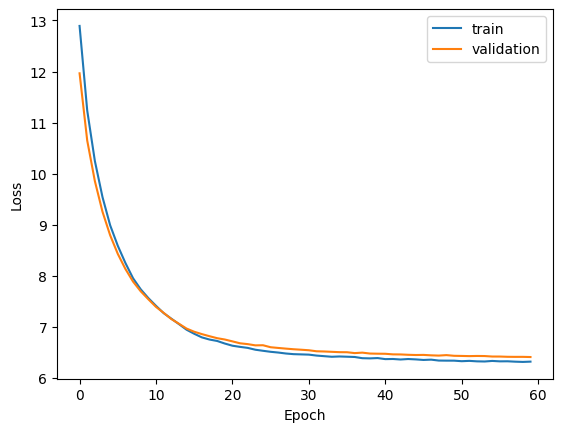

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the data
X_train = np.load('X_train_normalized.npy')
y_train = np.load('y_train.npy')

# Define the shared input layer
inputs = Input(shape=(X_train.shape[1],))

l2_regularizer = l2(0.01)

x = Dense(128, activation='relu', kernel_regularizer=l2_regularizer)(inputs)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2_regularizer)(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2_regularizer)(x)
x = Dropout(0.2)(x)

# Task-specific layers and outputs
outputs = []
for i in range(y_train.shape[1]):
    task_layer = Dense(16, activation='relu', kernel_regularizer=l2_regularizer)(x)
    task_layer = Dense(8, activation='relu', kernel_regularizer=l2_regularizer)(task_layer)
    output = Dense(1, activation='sigmoid', name=f'task_{i+1}')(task_layer)
    outputs.append(output)

model = Model(inputs=inputs, outputs=outputs)

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True
)
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss=['binary_crossentropy']*y_train.shape[1],
              metrics=[['accuracy']]*y_train.shape[1])

# Prepare the targets as a list for fitting to the multi-output model
y_train_list = [y_train[:, i] for i in range(y_train.shape[1])]

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with a modified batch size
history = model.fit(X_train, y_train_list,
                    epochs=60,
                    batch_size=32,  # Adjusted batch size
                    validation_split=0.2,
                    callbacks=[early_stopping])

# Save the model
model.save('HardParameter.h5')

# Plot the training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [30]:
# load the mode and make a prediction

model = tf.keras.models.load_model('HardParameter.h5')

X_test = np.load('X_test_normalized.npy')

y_pred = model.predict(X_test)

for i in range(len(y_pred)):
    for j in range(len(y_pred[i])):
        if y_pred[i][j] > 0.5:
            y_pred[i][j] = 1
        else:
            y_pred[i][j] = 0

print(y_pred)

# Save the predictions
np.save('y_pred.npy', y_pred)

ValueError: Input 0 of layer "functional_29" is incompatible with the layer: expected shape=(None, 97), found shape=(32, 106)